- 그림은 PITR의 기본 개념을 보여줍니다
- PITR 모드에서 PostgreSQL은 pg_backup_start에 의해 생성된 REDO 지점부터 복구하려는 지점까지 기본 백업에 있는 아카이브 로그의 WAL 데이터를 재생.
- PostgreSQL에서는 복구할 지점을 복구 대상 이라고 함.

**Basic concept of PITR.**

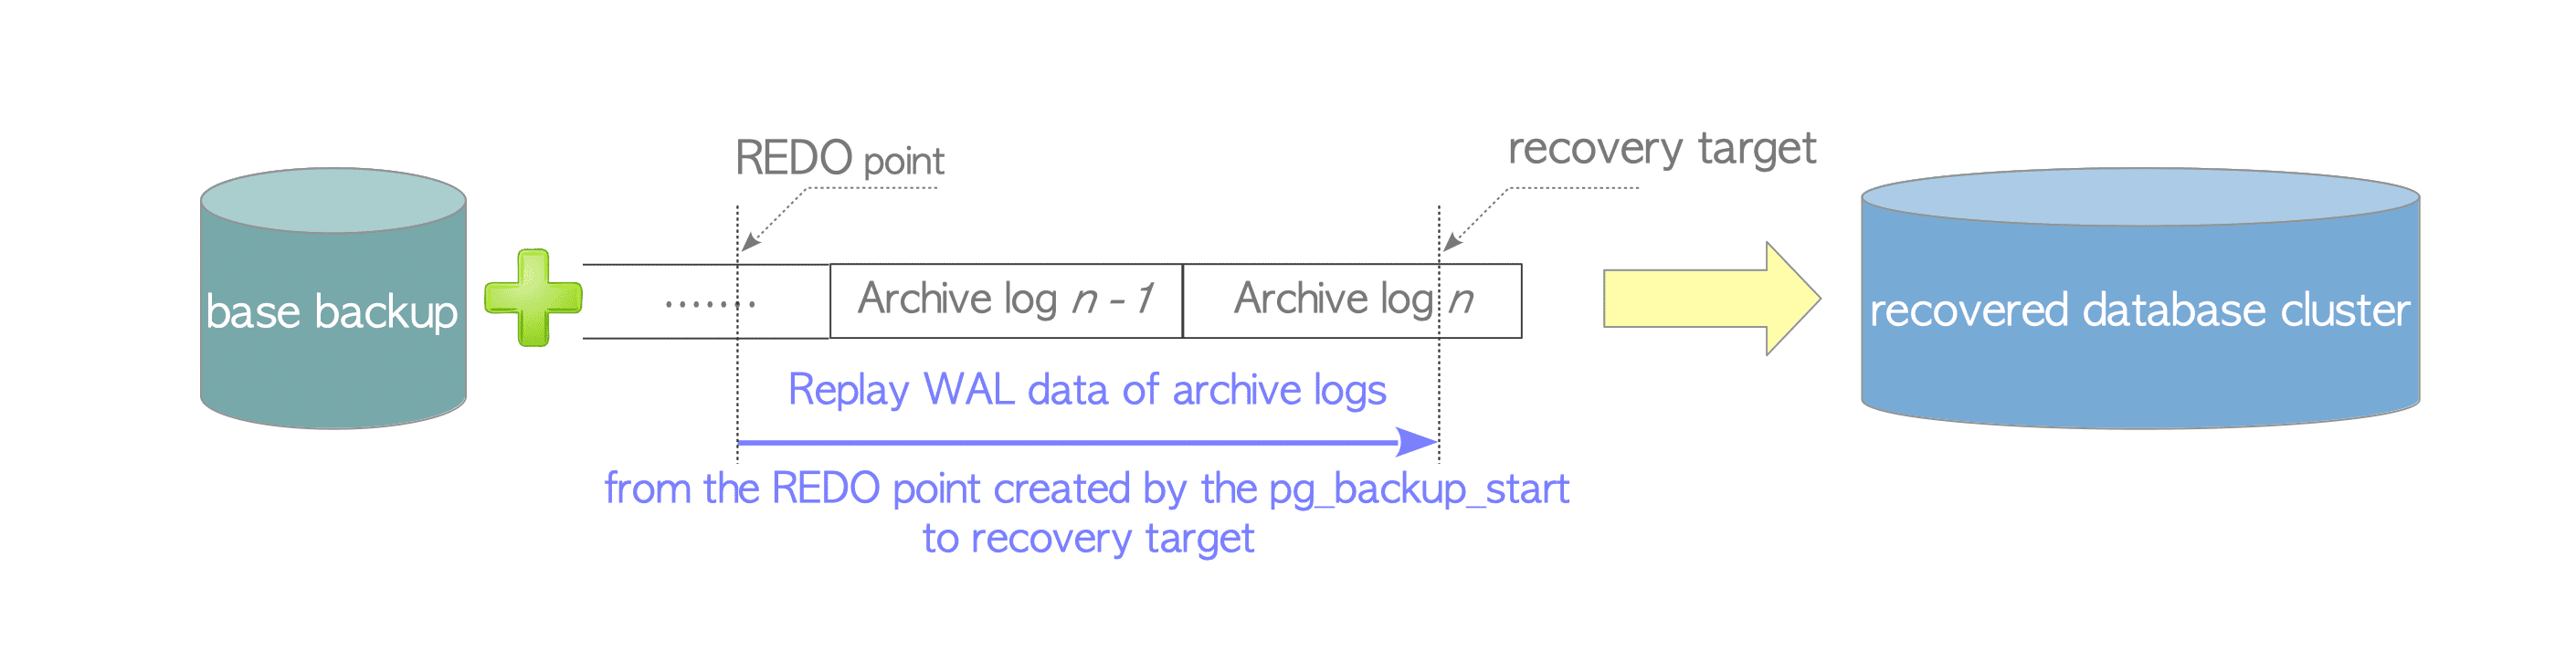

- 다음은 PITR의 작동 방식에 대한 설명.

- 2024년 1월 1일 12:05 GMT에 실수를 했다고 가정
- 데이터베이스 클러스터를 제거하고 이전에 만든 기본 백업을 사용하여 새 클러스터를 복원해야 함.

- 먼저 'restore_command' 매개변수의 명령을 설정하고, postgresql.conf에서 'recovery_target_time' 매개변수의 시간도 실수를 저지른 시점(이 경우 12:05 GMT)으로 설정해야 함
  - 버전 11 이하, Recovery.conf.



```
# Place archive logs under /mnt/server/archivedir directory.
restore_command = 'cp /mnt/server/archivedir/%f %p'
recovery_target_time = "2024-1-1 12:05 GMT"
```

- PostgreSQL을 시작할 때 데이터베이스 클러스터에 'backup_label' 파일과 ' recovery.signal ' 파일(버전 11 이하, 'recovery.conf') 이 있으면 PITR 모드로 진입 .

**Recovery.conf/recovery.signal**

- Recovery.conf 파일은 버전 12에서 폐지되었으며, 복구 관련 파라미터는 모두 postgresql.conf에 작성해야 함

- 버전 12 이상에서는 기본 백업에서 서버를 복원할 때 데이터베이스 클러스터 디렉터리에 Recovery.signal 이라는 빈 파일을 생성해야

```
$ touch /usr/local/pgsql/data/recovery.signal
```

- PITR(Point-in-Time Recovery) 프로세스는 9.8절 에서 설명한 일반 복구 프로세스와 거의 동일


**차이점**

1. WAL 세그먼트/아카이브 로그는 어디에서 읽혀지나요?
  - 일반 복구 모드 - 기본 디렉터리 아래의 pg_wal 하위 디렉터리(버전 9.6 이하에서는 pg_xlog 하위 디렉터리)에서.
  - PITR 모드 - 'archive_command' 매개변수에 설정된 보관 디렉터리에서.

2. 체크포인트 위치는 어디에서 읽어오나요?
  - 일반 복구 모드 - pg_control 파일에서.
  - PITR 모드 - backup_label 파일에서.


**PITR 프로세스의 개요**

1. PostgreSQL은 내부 함수 read_backup_label()을 사용하여 backup_label 파일에서 'CHECKPOINT LOCATION' 값을 읽어 REDO 지점을 찾음.

2. PostgreSQL은 postgresql.conf((버전 11 이하, Recovery.conf)에서 'restore_command' 및 'recovery_target_time'과 같은 일부 매개변수 값을 읽음.

3. PostgreSQL은 'CHECKPOINT LOCATION' 값으로 쉽게 알 수 있는 REDO 포인트부터 WAL 데이터 재생을 시작.
  - WAL 데이터는 'restore_command' 매개변수에 작성된 명령을 실행하여 아카이브 영역에서 임시 영역으로 복사된 아카이브 로그에서 읽어옴. (임시 영역에 복사된 로그 파일은 사용 후 제거됨.)
  - 이 예에서 PostgreSQL은 REDO 지점부터 타임스탬프 '2024-1-1 12:05:00' 이전의 WAL 데이터를 읽고 재생.
  - Recovery_target_time' 매개변수가 이 타임스탬프로 설정됨.
  - 복구 대상이 postgresql.conf(버전 11 이하, Recovery.conf)로 설정되지 않은 경우 PostgreSQL은 보관 로그가 끝날 때까지 재생

4. 복구 과정이 완료되면 pg_wal 하위 디렉터리(9.6 이전 버전에서는 pg_xlog 하위 디렉터리)에 '00000002.history'와 같은 타임라인 히스토리 파일이
생성됨.
  - 로그 보관 기능이 활성화된 경우 보관 디렉터리에도 동일한 이름의 파일이 생성됨

- 커밋 및 중단 작업의 레코드에는 각 작업이 수행된 타임스탬프가 포함됨(두 작업의 XLOG 데이터 부분은 xl_xact_commit그리고xl_xact_abort각기).


**xl_xact_commit**

```
typedef struct xl_xact_commit
{
        TimestampTz	xact_time;          /* time of commit */
        uint32          xinfo;              /* info flags */
        int            	nrels;              /* number of RelFileNodes */
        int            	nsubxacts;          /* number of subtransaction XIDs */
        int            	nmsgs;              /* number of shared inval msgs */
        Oid            	dbId;               /* MyDatabaseId */
        Oid            	tsId;               /* MyDatabaseTableSpace */
        /* Array of RelFileNode(s) to drop at commit */
        RelFileNode     xnodes[1];          /* VARIABLE LENGTH ARRAY */
        /* ARRAY OF COMMITTED SUBTRANSACTION XIDs FOLLOWS */
        /* ARRAY OF SHARED INVALIDATION MESSAGES FOLLOWS */
} xl_xact_commit;
```

**xl_xact_abort**

```
typedef struct xl_xact_abort
{
        TimestampTz     xact_time;          /* time of abort */
        int            	nrels;              /* number of RelFileNodes */
        int             nsubxacts;          /* number of subtransaction XIDs */
        /* Array of RelFileNode(s) to drop at abort */
        RelFileNode     xnodes[1];          /* VARIABLE LENGTH ARRAY */
        /* ARRAY OF ABORTED SUBTRANSACTION XIDs FOLLOWS */
} xl_xact_abort;
```

- 따라서 'recovery_target_time' 매개변수에 목표 시간을 설정하면 PostgreSQL은 커밋 또는 중단 작업의 XLOG 기록을 재생할 때마다 복구를 계속할지 여부를 선택할 수 있음
- 각 액션의 XLOG 레코드가 재생되면 PostgreSQL은 목표 시간과 레코드에 기록된 각 타임스탬프를 비교하여 타임스탬프가 목표 시간을 초과하면 PITR 프로세스가 종료됨.

**Info**
- read_backup_label() 함수는 src/backend/access/transam/xlog.c 에 정의되어 있음

- xl_xact_commit 및 xl_xact_abort 구조는 src/include/access/xact.h 에 정의되어 있음

<BR>

**Why can we use common archiving tools to make a base backup?**

- 복구 프로세스는 데이터베이스 클러스터가 일관성이 없는 경우에도 데이터베이스 클러스터를 일관된 상태로 복원하는 프로세스.
- PITR은 복구 프로세스를 기반으로 하므로 기본 백업이 일관되지 않은 파일 묶음인 경우에도 데이터베이스 클러스터를 복구할 수 있음
- 이것이 바로 파일 시스템 스냅샷 기능이나 특수 도구 없이도 일반적인 아카이빙 도구를 사용할 수 있는 이유